## Step0: Import libraries, Load data and Define helpful functions

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
from skimage.feature import hog
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import pickle
import os
import glob

print("Load Completed")

Load Completed


In [2]:
image_types = os.listdir('vehicles/')
cars = []
for imtype in image_types:
    cars.extend(glob.glob('vehicles/'+imtype+'/*'))
n_cars = len(cars)
    
print('Number of Vehicle Images found:', n_cars)
with open('cars.txt', 'w') as f:
    for fn in cars:
        f.write(fn+'\n')
        
image_types = os.listdir('non-vehicles/')
notcars = []
for imtype in image_types:
    notcars.extend(glob.glob('non-vehicles/'+imtype+'/*'))

n_notcars = len(notcars)    
print('Number of Non-Vehicle Images found:', n_notcars)
with open('notcars.txt', 'w') as f:
    for fn in notcars:
        f.write(fn+'\n')

Number of Vehicle Images found: 8792
Number of Non-Vehicle Images found: 8968


In [7]:
### Copy and modified helpful functions from the lessons

# Covert image to a specific colorspace
def convert_color(img, conv='RGB'):
    if conv == 'RGB':
        return img
    if conv == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# Extract HOG feature
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Extract spatial feature
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

# Extract color histogram feature
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function for plotting multiple images
def visualise(fig, rows, cols, imgs, titles, cmap='hot'):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.tight_layout()
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap=cmap)
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])
            
print('Functions defined ...')

Functions defined ...


---

## Step 1: Explore features

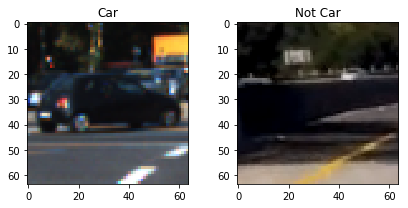

In [20]:
%matplotlib inline

# Randomly select the images of car and nonecar
car_ind = np.random.randint(0, n_cars)
notcar_ind = np.random.randint(0, n_notcars)

car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

titles = ['Car', 'Not Car']
images = []
images.append(car_image)
images.append(notcar_image)

fig = plt.figure(figsize=(6, 3))
visualise(fig, 1, 2, images, titles)
fig.savefig("output_images/carvsnotcar.jpg")

/Users/ElsaW/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


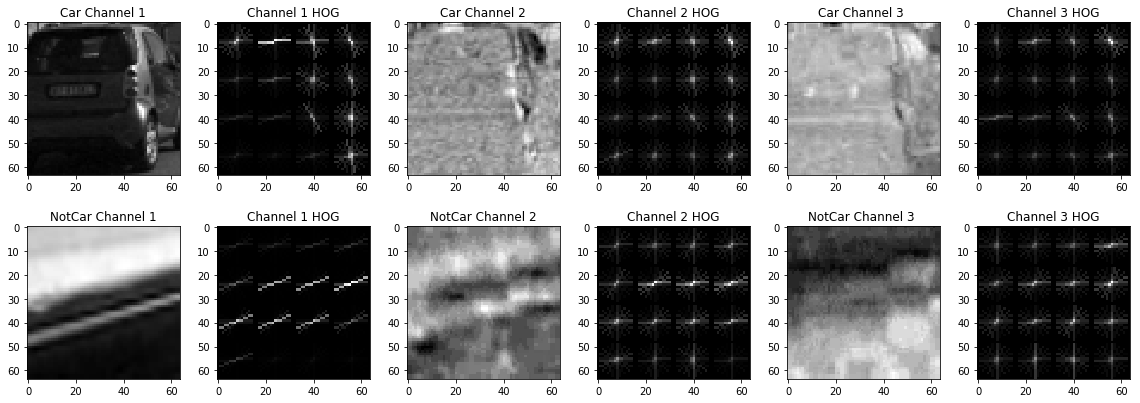

In [22]:
# Define function to explore the colourspace and HOG features
def explore(image, color_space='RGB', orient=9, pix_per_cell=8, cell_per_block=2):
    
    imgs = []
    imgs.append(image)
    
    feature_image = convert_color(image, conv=color_space)
    
    for i in range(feature_image.shape[2]):
        imgs.append(feature_image[:,:,i])
        hog_feature, hog_img = get_hog_features(feature_image[:,:,i], orient, pix_per_cell, cell_per_block,
                         vis=True, feature_vec=False)
        imgs.append(hog_img)
    
    return imgs       

car_ind = np.random.randint(0, n_cars)
notcar_ind = np.random.randint(0, n_notcars)

car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Explore HOG and Color spaces
color_spaces = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']

images = explore(car_image, color_space=color_spaces[5], orient=11, pix_per_cell=16)[1:]
images.extend(explore(notcar_image, color_space=color_spaces[5], orient=11, pix_per_cell=16,)[1:])

titles = ['Car Channel 1', 'Channel 1 HOG', 'Car Channel 2', 'Channel 2 HOG', 'Car Channel 3 ', 'Channel 3 HOG',
          'NotCar Channel 1', 'Channel 1 HOG', 'NotCar Channel 2', 'Channel 2 HOG', 'NotCar Channel 3 ', 'Channel 3 HOG']
fig = plt.figure(figsize=(16, 6))
visualise(fig, 2, 6, images, titles, cmap='gray')
fig.savefig("output_images/features_extraction.jpg")

---

## Step 2: Extract features from training data

In [7]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, spatial_size=(32, 32), color_space='RGB', hist_bins=32,
                        orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        
        file_features = []
        image = mpimg.imread(file)
        feature_image = convert_color(image, conv=color_space)
        
        if spatial_feat:
            # Apply bin_spatial() to get spatial color features
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
       
        if hist_feat:
            # Apply color_hist() also with a color space option now
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
            
        if hog_feat:
            # Apply get_hog_features() with vis=False, feature_vec=True
            if hog_channel == "ALL":
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel],
                                                orient, pix_per_cell, cell_per_block,
                                                vis=False, feature_vec=True))
                hog_features = np.concatenate(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel],
                                                orient, pix_per_cell, cell_per_block,
                                                vis=False, feature_vec=True)
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
        
    # Return list of feature vectors
    return features

In [11]:
# Define feature parameters
color_space = 'YCrCb'
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (32, 32)
hist_bins = 32
spatial_feat = True
hist_feat = True
hog_feat = True

#n_samples = 1000
#random_idxs = np.random.randint(0, n_cars, n_samples)
#test_cars = np.array(cars)[random_idxs]
#test_notcars = np.array(notcars)[random_idxs]

t = time.time()

car_feature = extract_features(cars,color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,
                              cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
notcar_feature = extract_features(notcars,color_space=color_space,spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,
                              cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

print(time.time()-t,  'Seconds to extract features...')

X = np.vstack((car_feature, notcar_feature)).astype(np.float64)
# Normlise the features
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
# Label odata
y = np.hstack((np.ones(len(car_feature)), np.zeros(len(notcar_feature))))

# Shuffle and Split data to training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size = 0.2, random_state = rand_state)

print("Training and test data are ready")
print("Feature vector length:", len(X_train[0]))

88.28999996185303 Seconds to extract features...
Training and test data are ready
Feature vector length: 4356


In [12]:
#t1 = time.time()
#svc_rbf = SVC()
#svc_rbf.fit(X_train, y_train)
#accuracy_rbf = svc_rbf.score(X_test, y_test)
t2 = time.time()
svc = LinearSVC()
svc.fit(X_train, y_train)
accuracy = svc.score(X_test, y_test)

#print(t2-t1, 'seconds to train rbf model')
#print('Test Accuracy of SVC = ', round(accuracy_rbf, 4))
print(time.time()-t2, 'seconds to train linear model')
print('Test Accuracy of SVC = ', round(accuracy, 4))

132.41600012779236 seconds to train linear model
Test Accuracy of SVC =  0.9927


In [13]:
features_pickle = {}
features_pickle["scaled_X"] = scaled_X
features_pickle["y"] = y
features_pickle["svc"] = svc
features_pickle["X_scaler"] = X_scaler
#features_pickle["svc_rbf"] = svc_rbf
pickle.dump(features_pickle, open("./features_pickle.p", "wb"))

print("Features and SVM Saved ...")

Features and SVM Saved ...


---

### !! Load extracted features and model

In [3]:
#Load saved features and model
features_pickle = pickle.load(open("./features_pickle.p", "rb"))
svc = features_pickle["svc"]
X_scaler = features_pickle["X_scaler"]

#Define feature parameters
color_space = 'YCrCb'
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (32, 32)
hist_bins = 32
spatial_feat = True
hist_feat = True
hog_feat = True

---

## Step 3: Sliding windows and searching car

In [8]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_sapce):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    heatmap = np.zeros_like(img[:,:,0])
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv=color_sapce)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
                                
    return draw_img, heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels, thick=6):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), thick)
    # Return the image
    return img

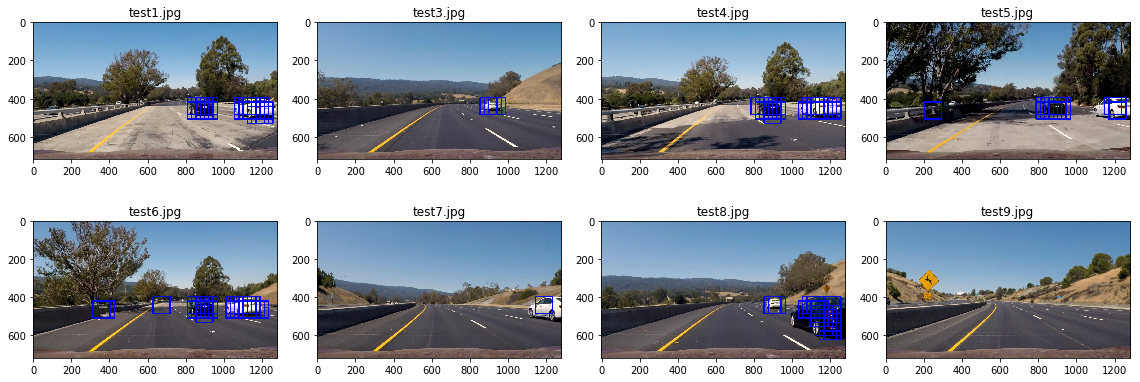

In [60]:
%matplotlib inline

test_images = glob.glob('test_images/*')
out_images = []
out_titles = []

ystart = 400
ystop = 670
scale = 1.4 #1.3-1.5

for img_src in test_images:
    img = mpimg.imread(img_src)
    draw_img, heatmap = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)
    
    out_titles.append(img_src[-9:])
    out_images.append(draw_img)
    
fig = plt.figure(figsize=(16,6))
visualise(fig, 2, 4, out_images, out_titles)
fig.savefig("output_images/windows_sliding.jpg")

0.3231480121612549  for each images


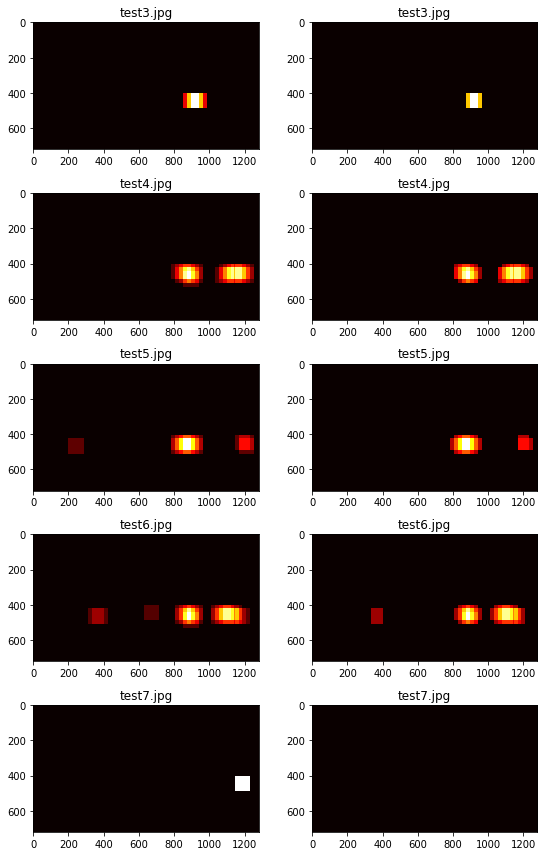

In [62]:
out_heat = []
out_labeled = []
out_titles1 = []
out_titles2 = []
t = time.time()

for img_src in test_images[1:6]:
    
    img = mpimg.imread(img_src)
    
    draw_img, heatmap = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)    
    out_heat.append(heatmap)
    
    
    heat = apply_threshold(np.copy(heatmap),1)
    out_heat.append(heat)

    labels = label(heat)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    out_labeled.append(draw_img)
    
    out_titles1.append(img_src[-9:])
    out_titles2.append(img_src[-9:])
    out_titles2.append(img_src[-9:])

print((time.time()-t)/len(test_images), " for each images")
fig = plt.figure(figsize=(8,12))
visualise(fig, 5, 2, out_heat, out_titles2)
fig.savefig("output_images/heatmap_thresholded.jpg")

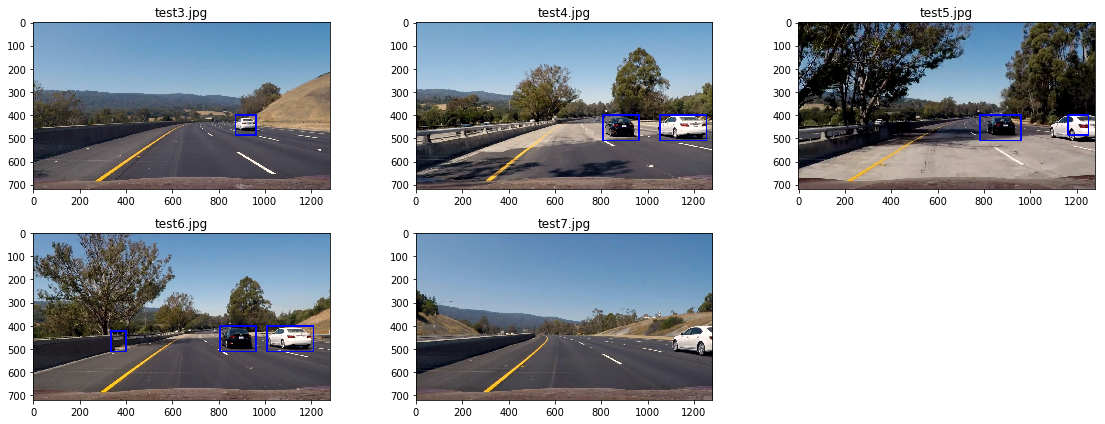

In [63]:
fig = plt.figure(figsize=(16,6))
visualise(fig, 2, 3, out_labeled, out_titles1)
fig.savefig("output_images/labeled.jpg")

---

## Step 4: Implement Video

In [25]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [34]:
from collections import deque

def pipeline(img):
    global heatmaps
    out_img, heat_map = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)
    heatmaps.append(heat_map)
    summed_heatmap = np.average(heatmaps, axis = 0)
    heat = apply_threshold(summed_heatmap,1) 
    labels = label(heat)
    draw_img = draw_labeled_bboxes(np.copy(img), labels, thick = 4)
    return draw_img

In [35]:
heatmaps = deque(maxlen = 12)

test_output = 'output_test.mp4'
clip = VideoFileClip("test_video.mp4")
test_clip = clip.fl_image(pipeline)
%time test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video output_test.mp4
[MoviePy] Writing video output_test.mp4


 97%|█████████▋| 38/39 [00:21<00:00,  1.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_test.mp4 

CPU times: user 18.6 s, sys: 1.94 s, total: 20.6 s
Wall time: 23.7 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format(test_output))

In [41]:
heatmaps = deque(maxlen = 10)
output = 'project5.mp4'
clip = VideoFileClip("project_video.mp4")
output_clip = clip.fl_image(pipeline)
#output_clip = clip.fl_image(pipeline).subclip(27, 29)
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project5.mp4
[MoviePy] Writing video project5.mp4


100%|█████████▉| 1260/1261 [11:26<00:00,  1.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project5.mp4 

CPU times: user 9min 59s, sys: 49.5 s, total: 10min 49s
Wall time: 11min 28s


In [ ]:
HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format(output))